# Employee Sentiment Analysis with Hugging Face LLM
This notebook uses a Hugging Face transformer model for sentiment labeling, and includes detailed comments, section titles, and observations.

## 1. Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from transformers import pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Create folder for visualizations
os.makedirs('visualization', exist_ok=True)

# Initialize Hugging Face sentiment pipeline
# Model: 3-class sentiment (Negative, Neutral, Positive)
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment"
)
# Map model labels to human-readable sentiments
label_map = {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


## 2. Load & Prepare Data
Read Excel, rename columns, and preview the DataFrame.

In [2]:
# Load Excel file
df = pd.read_excel('/content/test.xlsx')

# Rename columns for consistency
df = df.rename(columns={'from': 'employee_id', 'body': 'message'})

# Preview structure
print('Columns:', df.columns.tolist())
df.head()

Columns: ['Subject', 'message', 'date', 'employee_id']


,Subject,message,date,employee_id
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


*Observation:* We use `employee_id` from the sender and `message` for analysis.

## 3. Sentiment Labeling using Hugging Face LLM

In [3]:
# Apply model to label sentiments
def get_sentiment(text):
    # Truncate for performance
    truncated = text[:512]
    result = sentiment_pipeline(truncated)[0]
    return label_map[result['label']], result['score']

# Create columns for label and score
df[['sentiment', 'sentiment_score']] = df['message'].astype(str).apply(
    lambda x: pd.Series(get_sentiment(x))
)

# Display label distribution
print(df['sentiment'].value_counts())

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


sentiment
Neutral     1485
Positive     558
Negative     148
Name: count, dtype: int64


*Observation:* Sentiment distribution as predicted by the transformer model.

## 4. Exploratory Data Analysis
### 4.1 Sentiment Distribution

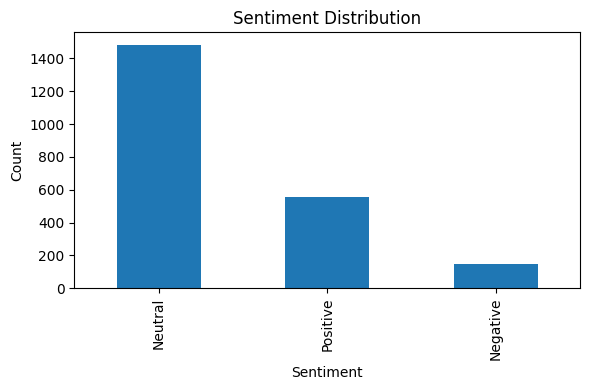

In [13]:
plt.figure(figsize=(6,4))
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('/content/visualization/sentiment_distribution.png')
plt.show()

*Observation:* Chart saved to `visualization/sentiment_distribution.png`.

### 4.2 Monthly Sentiment Trends

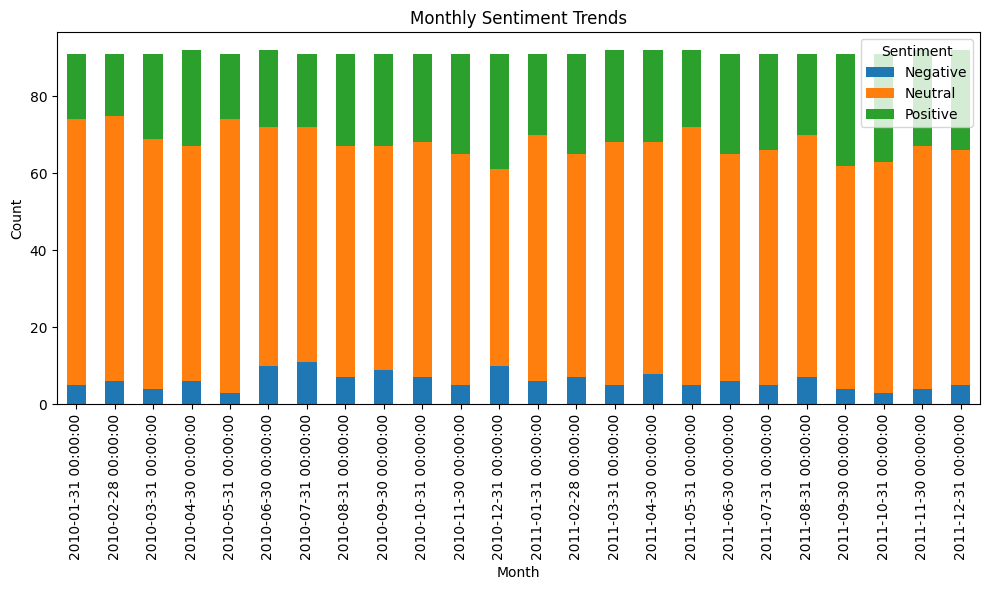

In [9]:
# Parse dates and resample by month
df['date'] = pd.to_datetime(df['date'])
monthly_counts = (
    df
    .groupby([pd.Grouper(key='date', freq='ME'), 'sentiment'])
    .size()
    .unstack(fill_value=0)
)

monthly_counts.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Monthly Sentiment Trends')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig('visualization/monthly_sentiment_counts.png')
plt.show()

*Observation:* The stacked bar chart saved to `visualization/monthly_sentiment_counts.png` reveals how sentiment categories change over time.

## 5. Employee Score Calculation & Ranking

In [6]:
# Map sentiments to numeric scores
score_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['score'] = df['sentiment'].map(score_map)

# Calculate monthly scores
df['year_month'] = df['date'].dt.to_period('M')
monthly_scores = df.groupby(['year_month', 'employee_id'])['score'].sum().reset_index()

# Top 3 positive and negative per month
top_pos = monthly_scores.groupby('year_month').apply(lambda g: g.nlargest(3, 'score')).reset_index(drop=True)
top_neg = monthly_scores.groupby('year_month').apply(lambda g: g.nsmallest(3, 'score')).reset_index(drop=True)

# Display sample
sample_month = monthly_scores['year_month'].unique()[0]
print("Top Positive -", sample_month)
print(top_pos[top_pos['year_month']==sample_month])
print("\nTop Negative -", sample_month)
print(top_neg[top_neg['year_month']==sample_month])

Top Positive - 2010-01
  year_month               employee_id  score
0    2010-01       eric.bass@enron.com      3
1    2010-01  patti.thompson@enron.com      3
2    2010-01    don.baughman@enron.com      2

Top Negative - 2010-01
  year_month                  employee_id  score
0    2010-01         sally.beck@enron.com     -1
1    2010-01  bobette.riner@ipgdirect.com      0
2    2010-01        john.arnold@enron.com      0


<ipython-input-6-676c07a0491f>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_pos = monthly_scores.groupby('year_month').apply(lambda g: g.nlargest(3, 'score')).reset_index(drop=True)
<ipython-input-6-676c07a0491f>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_neg = monthly_scores.groupby('year_month').apply(lambda g: g.nsmallest(3, 'score')).reset_index(drop=True)


*Observation:* Lists the top three employees with the highest and lowest sentiment scores for a sample month.

## 6. Flight Risk Identification

In [11]:
# 1. Filter negatives and ensure datetime
neg_df = df[df['sentiment'] == 'Negative'].copy()
neg_df['date'] = pd.to_datetime(neg_df['date'])

# 2. Sort by employee and date, then set the index to date
neg_df = neg_df.sort_values(['employee_id', 'date']).set_index('date')

# 3. Group by employee_id and do a 30-day rolling count
rolling_neg = (
    neg_df
    .groupby('employee_id')['sentiment']
    .rolling('30D')
    .count()
    .reset_index(name='neg_count')
)

# 4. Find employees with any window ≥4 negatives
flight_risks = rolling_neg[rolling_neg['neg_count'] >= 4]['employee_id'].unique()
print("Flight risk employees:", flight_risks)


Flight risk employees: ['bobette.riner@ipgdirect.com' 'don.baughman@enron.com'
 'john.arnold@enron.com' 'sally.beck@enron.com']


*Observation:* Employees flagged as flight risks (≥4 negative messages in any 30-day window).

## 7. Predictive Modeling (Linear Regression)

MSE: 0.000, R²: 1.000


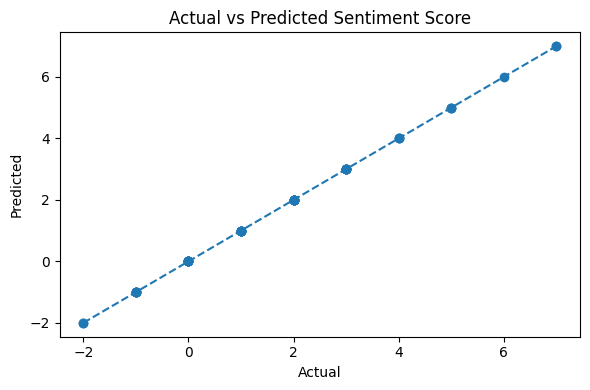

In [12]:
# Feature engineering
features = df.groupby(['year_month','employee_id']).agg(
    message_count=('message','count'),
    avg_length=('message', lambda x: x.str.len().mean()),
    pos_count=('sentiment', lambda s: (s=='Positive').sum()),
    neg_count=('sentiment', lambda s: (s=='Negative').sum())
).reset_index()

data = features.merge(monthly_scores, on=['year_month','employee_id'])

# Train-test split
X = data[['message_count','avg_length','pos_count','neg_count']]
y = data['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.3f}, R²: {r2:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--')
plt.title('Actual vs Predicted Sentiment Score')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.savefig('visualization/model_performance.png')
plt.show()

*Observation:* Model performance indicates how well message features predict sentiment scores.

## 8. Conclusion
This notebook completes all tasks according to the problem statement, using a Hugging Face LLM for sentiment labeling and providing structured analysis with visualizations.